In [2]:
import numpy as np # standard package for doing calculations
import matplotlib.pyplot as plt # standard package for plotting
import os
import analysis_tools as at 

from lsst.ts.wep.task.GenerateDonutDirectDetectTask import (
    GenerateDonutDirectDetectTaskConfig, GenerateDonutDirectDetectTask
)

from lsst.ts.wep.task.CutOutDonutsScienceSensorTask import (
    CutOutDonutsScienceSensorTaskConfig, CutOutDonutsScienceSensorTask
)

from lsst.ts.wep.task.CalcZernikesTask import (
    CalcZernikesTask, CalcZernikesTaskConfig
)


from lsst.obs.lsst import LsstCam
import lsst.afw.image as afwImage
from lsst.afw.geom import makeSkyWcs,  makeCdMatrix
import numpy as np
from astropy.time import Time
from lsst.obs.lsst import Latiss
import lsst

from copy import copy

INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Take batoid simulation, make exposure, with with WEP transpose and no transpose... 

DM-37533/auxtel_b_seed0_image_truth_z5.npz


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 71 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 71 of 71 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-5.1.0/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:64: RuntimeWarning: divide by zero encountered in log10
  return dex.to(self._function_unit, np.log10(x))
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 1/71 references
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 100 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 100 of 100 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-5.1.0/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:64: RuntimeWarning: divide by zero encountered in log10
  return dex.to(self._function_unit, n

[[-7.04517956e-03 -1.23731960e-01 -1.11302854e-02 -2.83425176e-03
   9.72133870e-03  4.04435491e-03 -9.47079016e-04  2.69730761e-04
   1.51851927e-04  3.27107850e-05  2.07242569e-04  5.59952381e-04
  -1.03133006e-03  2.26271369e-04  3.97540125e-04  3.99577956e-05
   9.66893934e-04 -1.51968527e-03  8.36137314e-05]]
DM-37533/auxtel_b_seed0_image_truth_z6.npz


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 64 sources in exposure


InvalidParameterError: 
  File "src/image/Mask.cc", line 394, in static int lsst::afw::image::Mask<MaskPixelT>::getMaskPlane(const string&) [with MaskPixelT = int; std::string = std::__cxx11::basic_string<char>]
    Invalid mask plane name: NO_DATA {0}
lsst::pex::exceptions::InvalidParameterError: 'Invalid mask plane name: NO_DATA'


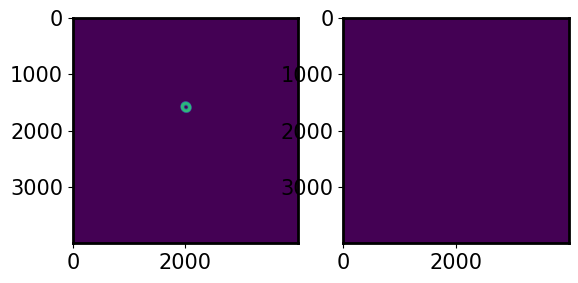

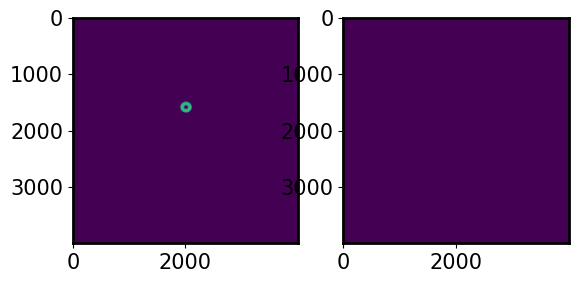

In [3]:
# Load a saved simulation image 

for i in range(5,7):
    seed=0
    fname = f"auxtel_b_seed{seed}_image_truth_z{i}.npz"
    fpath = os.path.join('DM-37533',fname)
    print(fpath)
    npz = np.load(fpath)
    intra_image = npz['intra']
    extra_image = npz['extra']
    zk = npz['zktruth']

    # make exposure
    intra_exposure = at.make_exposure(intra_image, focusZ=0.8)
    extra_exposure = at.make_exposure(extra_image, focusZ=-0.8)

    fia,ax = plt.subplots(1,2)
    ax[0].imshow(intra_exposure.image.array)
    ax[1].imshow(intra_exposure.mask.array)
    
    # common settings for donut detection task,
    # donut cutting out task zernike estimation task...
    
    focalLength = 21.6 # meters 
    obscuration = 0.3525 # ratio 
    apertureDiameter = 1.2 # meters 
    defocalOffset = 32.8 
    pixelSize = 10.0e-6 # meters 
    opticalModel = 'onAxis'
    # pass to WEP, fit transposed and untransposed 

    newConfig = GenerateDonutDirectDetectTaskConfig()
    newConfig.measurementTask.nSigmaDetection = 5
    newConfig.initialCutoutPadding = 40
    
    # Set auxTel parameters
    newConfig.instObscuration = obscuration
    newConfig.instFocalLength = focalLength
    newConfig.instApertureDiameter = apertureDiameter
    newConfig.instDefocalOffset = defocalOffset
    newConfig.instPixelSize = pixelSize
    newConfig.opticalModel = opticalModel
    
    # Set donut selection parameters
    newConfig.donutSelector.useCustomMagLimit = True
    newConfig.donutSelector.magMin = 8.
    newConfig.donutSelector.magMax = 20.
    newConfig.donutSelector.unblendedSeparation = 200


    camera = Latiss().getCamera()
    newTask = GenerateDonutDirectDetectTask(config=newConfig)
    donut_catalog_intra = newTask.run(copy(intra_exposure), camera).donutCatalog
    donut_catalog_extra = newTask.run(copy(extra_exposure), camera).donutCatalog

    cutOutConfig = CutOutDonutsScienceSensorTaskConfig()
    cutOutConfig.instObscuration = obscuration
    cutOutConfig.instFocalLength = focalLength
    cutOutConfig.instApertureDiameter = apertureDiameter
    cutOutConfig.instDefocalOffset = defocalOffset
    cutOutConfig.instPixelSize = pixelSize
    cutOutConfig.opticalModel = opticalModel
    cutOutConfig.donutStampSize = 200
    cutOutConfig.donutTemplateSize = 200
    cutOutConfig.initialCutoutPadding = 40

    cutOutTask = CutOutDonutsScienceSensorTask(config=cutOutConfig)
    cutOuts = cutOutTask.run([extra_exposure, intra_exposure], 
                             [donut_catalog_extra, donut_catalog_intra], 
                             camera)


    calcZernikesConfig = CalcZernikesTaskConfig()
    calcZernikesConfig.instObscuration = obscuration
    calcZernikesConfig.instFocalLength = focalLength
    calcZernikesConfig.instApertureDiameter =apertureDiameter
    calcZernikesConfig.instDefocalOffset = defocalOffset
    calcZernikesConfig.instPixelSize = pixelSize
    calcZernikesConfig.opticalModel = opticalModel
    calcZernikesConfig.combineZernikes.sigma=2

    # Initiate the task with our given configuration
    calcZernikesTask = CalcZernikesTask(config=calcZernikesConfig)

    # Run the CalcZernikes task
    calcZernikesOutput = calcZernikesTask.run(
        cutOuts.donutStampsExtra, 
        cutOuts.donutStampsIntra)

    # illustrate the donut stamp, result transposed, result untransposed, input... 

    zernOutRaw = calcZernikesOutput.outputZernikesRaw
    zernOutAvg = calcZernikesOutput.outputZernikesAvg

    print(zernOutRaw)



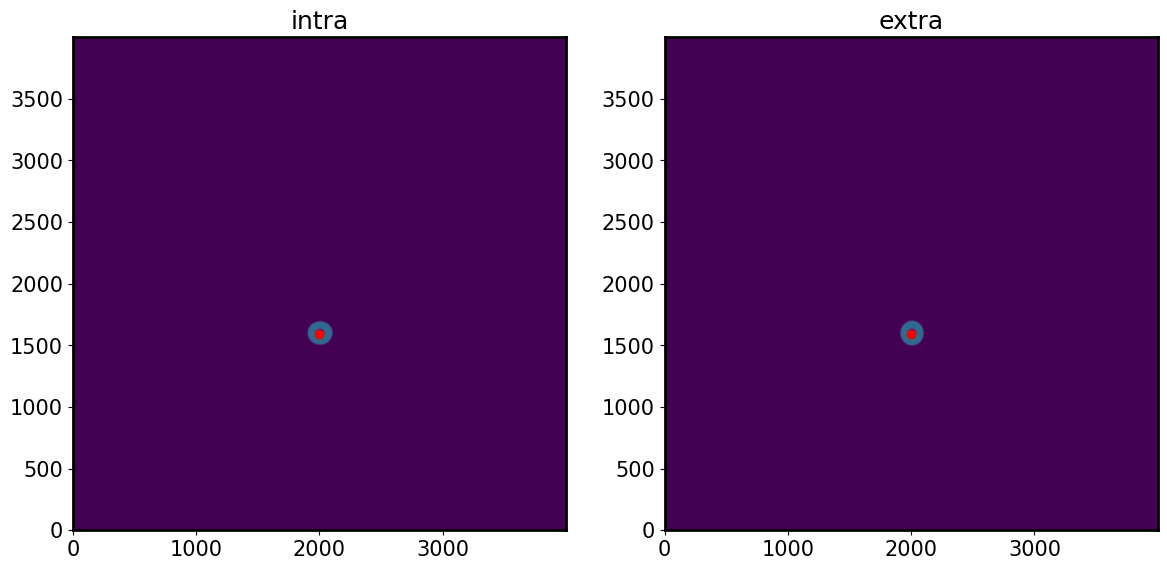

In [5]:
fig,ax  = plt.subplots(1,2, figsize=(14,7))
N=5
i =0 
for label, catalog, exposure in zip(['intra','extra'],
                      [donut_catalog_intra, donut_catalog_extra],
                     # [donut_catalog_intra_sorted, donut_catalog_extra_sorted],
                      [intra_exposure, extra_exposure]
                                   ):
    ax[i].imshow(exposure.getImage().getArray(), vmin=0, vmax=200.,
                origin='lower')
    ax[i].scatter(catalog['centroid_x'], 
                  catalog['centroid_y'], c='r',)#label='intra)
#     ax[i].scatter(sorted_catalog['centroid_x'][:N], 
#                   sorted_catalog['centroid_y'][:N], c='b', s=100, alpha=0.3,
#                  )
    ax[i].set_title(label)
    i+=1

??? why is it finding all the sources when there's absolutely nothing there ? 

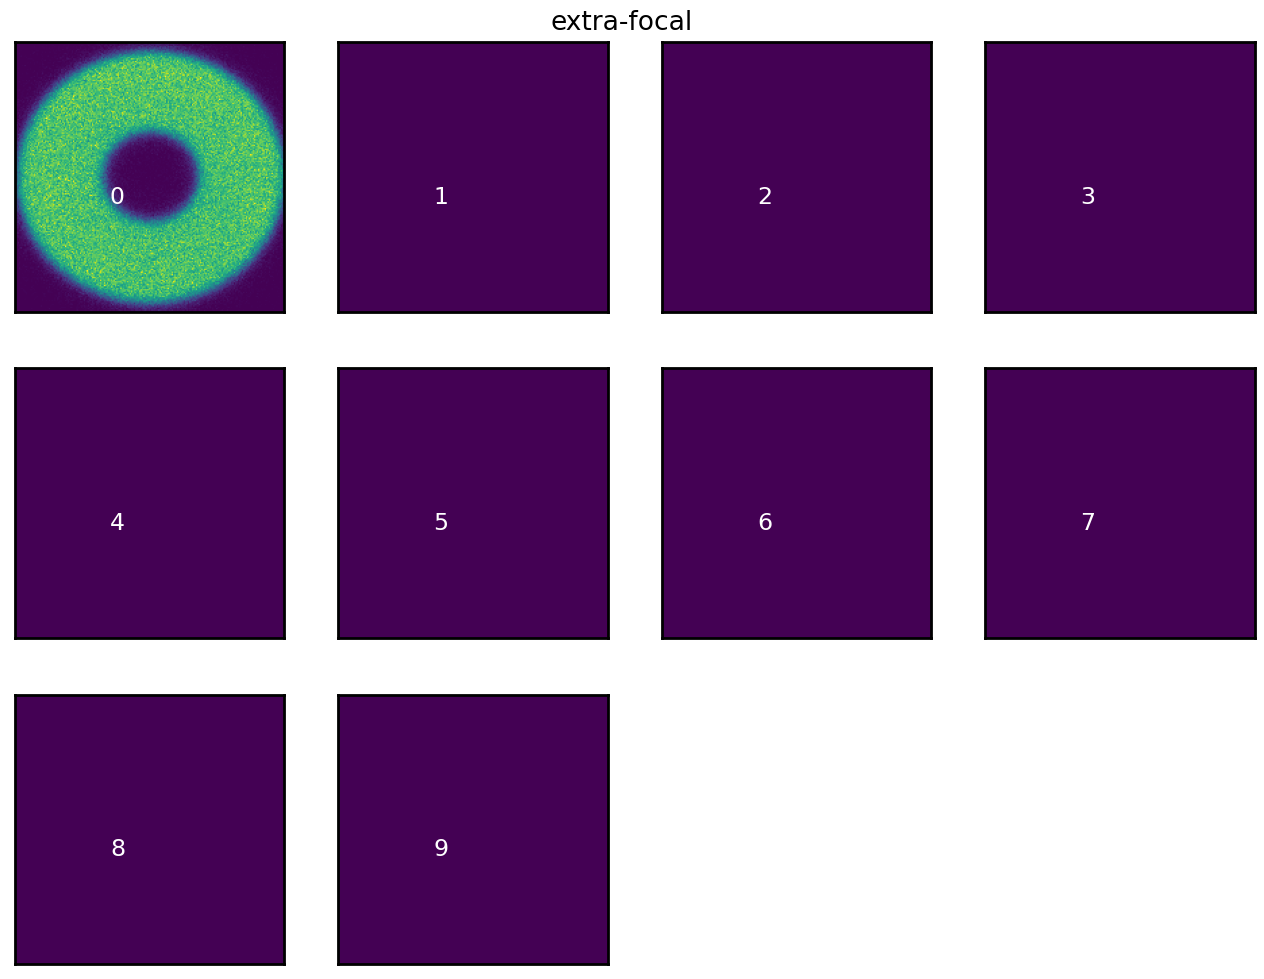

In [7]:
import algoritm_functions as af
af.plot_stamps(cutOuts.donutStampsIntra, title='extra-focal', #N=len(cutOuts.donutStampsIntra),
              ncols=3)

These are definitely empty stamps! Very very suspicious... 